# Homogenized model simplified circuit-Object oriented V1.0.0
**E is electrolyte potential $\phi$**
+ with controlled Eref range
+ updated guess from previous scan point


In [5]:
%matplotlib notebook
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
import pandas as pd
from __future__ import division

In [6]:
class corrparam:
    """E i properties object, use butler-volmer equation, could be extented with more complex kinetics"""
    def __init__(self,Eeq,i0,Ba,Bc):
        self.Eeq = Eeq
        self.i0 = i0
        self.Ba = Ba
        self.Bc = Bc
    def ia(self, E):
        return self.i0*10**((E-self.Eeq)/self.Ba)

    def ic(self, E):
        return -self.i0*10**((E-self.Eeq)/self.Bc)    

    def inet(self, E):
        return self.ia(E)+self.ic(E)


In [7]:
def itot(E1,E2,par1,par2,A1,A2):
    """High-level net current"""
    itot = par1.inet(E1)*A1 + par2.inet(E2)*A2
    return itot

def E_homo(E1,E2,A1,A2):
    """area-averaged homogenized potential"""
    return (E1*A1 + E2*A2)/(A1+A2)

In [8]:
# objective function finding E1,E2 at Open circuit
def E1E2_OC_obj_f(E1E2,model):
    E1 = E1E2[0]
    E2 = E1E2[1]
    obj1 = model.par1.inet(-E1)*model.A1*model.Area+model.par2.inet(-E2)*model.A2*model.Area
    obj2 = E1-E2-(model.par1.inet(-E1)*model.A1*model.Area)*1/(1/(model.R1+model.R2)+1/model.R0)
    return [obj1,obj2]


# objective function Krichhoff's law
def objective_f(unknowns,model,Ec):
    # E1,E2,Ec are all electrolyte potential

    E1,E2,I1,I2,I1_e,I2_e,I0 = unknowns


    obj1 = I1 -I0-I1_e
    obj2 = I2 +I0-I2_e

    obj3 = I1_e*model.R1 -I2_e*model.R2-I0*model.R0
    obj4 = 0-E1 + I0*model.R0 +E2 -0

    obj5 = Ec-0+(0-E1)+I1_e*model.R1

    obj6 = I1 - model.par1.inet(-E1)*model.Area*model.A1
    obj7 = I2 - model.par2.inet(-E2)*model.Area*model.A2
    return [obj1,obj2,obj3,obj4,obj5,obj6,obj7]


In [9]:
class model_set:
    """set mode parameters and solve properties"""
    def __init__(self,par1,par2,Area,A1,A2,R0,Re):
        self.par1 = par1
        self.par2 = par2
        self.Area = Area
        self.A1 = A1
        self.A2 = A2
        self.R0 = R0
        self.Re = Re
        self.R1 = Re*(A1+A2)/A1
        self.R2 = Re*(A1+A2)/A2
        self.comment = ''
        
    def find_OCP_icorr(self): 
        from scipy.optimize import fsolve
        ini_guess = [self.par1.Eeq, self.par2.Eeq]

        E1E2 = fsolve(E1E2_OC_obj_f,ini_guess, args=(self),xtol=1e-12)
        self.OCP = - (E1E2[0]*self.A1 + E1E2[1]*self.A2)
        self.icorr = self.par1.inet(-E1E2[0])*self.A1
        return E1E2

        
    def solve(self,plot_residual=False,cathodic_range=-0.15,anodic_range=0.15, scan_step=0.005):
        # open circuit
        E1E2 = self.find_OCP_icorr()
        
        # Potentio-dynamic scan
        from scipy.optimize import fsolve        
               
        # inital step initial guess, 
        sol = [E1E2[0], E1E2[1], 
               self.icorr*self.Area, -self.icorr*self.Area,
               0.,0,self.icorr*self.Area] #E1,E2,I1,I2,I1_e,I2_e,I0
        
        sol_list = []
        Eapp_list = []
        
        # cathodic branch
        Ec = -self.OCP-0.001
        while -E_homo(sol[0],sol[1],self.A1,self.A2) >= (self.OCP+cathodic_range): #Eref->Eref-150mV
            Ec += scan_step
         
            sol = fsolve(objective_f,sol, args=(self,Ec),xtol=1e-12) # use previous sol as initial guess
            sol_list.append(sol)
            Eapp_list.append(Ec)
        
        sol_list = list(reversed(sol_list))# reverse squence to have one direction from cathode to anode
        Eapp_list = list(reversed(Eapp_list))
        
        # anodic branch
        Ec = -self.OCP+0.001
        while -E_homo(sol[0],sol[1],self.A1,self.A2) <= (self.OCP+anodic_range): #Eref->Eref+150mV
            Ec -= scan_step
            sol = fsolve(objective_f,sol, args=(self,Ec),xtol=1e-12)
            sol_list.append(sol)
            Eapp_list.append(Ec)

            
        # add solution to model
        self.E1 = np.array([this[0]for this in sol_list])
        self.E2 = np.array([this[1]for this in sol_list])
        self.I1 = np.array([this[2]for this in sol_list])
        self.I2 = np.array([this[3]for this in sol_list])
        self.I1_e = np.array([this[4]for this in sol_list])
        self.I2_e = np.array([this[5]for this in sol_list])
        self.I0 = np.array([this[6]for this in sol_list])
        
        self.Eapp_list = np.array(Eapp_list)
        self.Eref = -E_homo(self.E1,self.E2,self.A1,self.A2)
        self.IRcomp = (self.I1_e+self.I2_e)*self.Re

        residu = np.array([objective_f(sol_list[i],self,self.Eapp_list[i]) for i in range(len(self.Eapp_list))])
        print 'total residual', np.sum(np.abs(residu))
        if plot_residual:
            plt.figure(figsize=(8,4))

            for i in range(7):
                r_obj = [r[i] for r in residu]
                plt.plot(self.Eref,r_obj,'-',label=str(i))
            plt.xlabel('$E_{ref}$ [V]')    
            plt.title('residual')
            plt.legend(['E1','E2','I1','I2','I1_e','I2_e','I0'])

    def unpack_solution(self):
        return (self.E1, self.E2,self.I1,self.I2,
                self.I1_e, self.I2_e, self.I0,
                self.Eapp_list,self.Eref, self.IRcomp)
        


In [10]:
# plot function

def potential_plot(model):
    E1,E2,I1,I2,I1_e,I2_e,I0,Eapp_list, Eref,IRcomp = model.unpack_solution()
    
    plt.figure()
    plt.plot(Eref,-E2,'C0',label='Passive unit potential, $E^{pas}$')
    plt.plot(Eref,-E1,'C1',label='Active unit potential, $E^{act}$')
    plt.plot(Eref,Eref,'C2',label='Homogenized rebar potential,$<E_{rebar}>$')
    plt.plot(Eref,-Eapp_list,'C3',label='Concrete cover potential, $-\phi_{app}$')
    plt.plot(Eref,-(Eapp_list+IRcomp),':C3',label='Rebar potential with IRcomp, $E_{rebar}^{IRcomp}$',linewidth=2)

    plt.xlabel('Homogenized rebar potential, [V]',fontsize=8)
    plt.ylabel('Electrode potential [V]',fontsize=8)
#     plt.axis('equal')
    plt.legend(bbox_to_anchor=(1,1))
    plt.tight_layout()
    plt.show()
    
def plot_cover_potential_subplot(model, title, subplot):
    E1,E2,I1,I2,I1_e,I2_e,I0,Eapp_list, Eref,IRcomp = model.unpack_solution()
    
#     subplot.plot(Eref,-E2,'C0',label='Passive unit potential, $E^{pas}$')
#     subplot.plot(Eref,-E1,'C1',label='Active unit potential, $E^{act}$')
    subplot.plot(Eref,Eref,'C2',label='Homogenized rebar potential,$<E_{rebar}>$')
    subplot.plot(Eref,-Eapp_list,'C3',label='Concrete cover potential, $-\phi_{app}$')
#     subplot.plot(Eref,-(Eapp_list+IRcomp),':C3',
#                  label='Rebar potential with IRcomp, $E_{rebar}^{IRcomp}$',linewidth=2)

#     subplot.set_xlabel('Homogenized rebar potential, [V]',fontsize=9)
#     subplot.set_ylabel('Electrode potential [V]',fontsize=9)
#     subplot.axis('equal')
#     subplot.set_xlim((model.OCP-0.3,model.OCP+0.3))

    subplot.xaxis.set_major_locator(ticker.MultipleLocator(0.2))
#     subplot.xaxis.set_minor_locator(ticker.MultipleLocator(0.05))
#     subplot.yaxis.set_major_locator(ticker.MultipleLocator(0.1))
#     subplot.yaxis.set_minor_locator(ticker.MultipleLocator(0.05))
    
    plt.tight_layout()
    subplot.set_title(title,fontsize=10)
    
def plot_potential_subplot(model, title, subplot):
    E1,E2,I1,I2,I1_e,I2_e,I0,Eapp_list, Eref,IRcomp = model.unpack_solution()
    
    subplot.plot(Eref,-E2,'C0',label='Passive unit potential, $E^{pas}$')
    subplot.plot(Eref,-E1,'C1',label='Active unit potential, $E^{act}$')
    subplot.plot(Eref,Eref,'C2',label='Homogenized rebar potential,$<E_{rebar}>$')
#     subplot.plot(Eref,-Eapp_list,'C3',label='Concrete cover potential, $-\phi_{app}$')
    subplot.plot(Eref,-(Eapp_list+IRcomp),':C3',
                 label='Rebar potential with IRcomp, $E_{rebar}^{IRcomp}$',linewidth=2)

#     subplot.set_xlabel('Homogenized rebar potential, [V]',fontsize=9)
#     subplot.set_ylabel('Electrode potential [V]',fontsize=9)
#     subplot.axis('equal')
#     subplot.set_xlim((model.OCP-0.3,model.OCP+0.3))

    subplot.xaxis.set_major_locator(ticker.MultipleLocator(0.1))
    subplot.xaxis.set_minor_locator(ticker.MultipleLocator(0.05))
    subplot.yaxis.set_major_locator(ticker.MultipleLocator(0.1))
    subplot.yaxis.set_minor_locator(ticker.MultipleLocator(0.05))
    
    plt.tight_layout()
    subplot.set_title(title,fontsize=10)
    
def plot_Ei_log_subplot(model,title,subplot):
    E1,E2,I1,I2,I1_e,I2_e,I0,Eapp_list, Eref,IRcomp = model.unpack_solution()
    AREA, A1, A2 = model.Area, model.A1, model.A2
    
    subplot.plot(np.abs(I1)/(AREA),Eref,'C1',label='Active unit, averaged over whole area')
    subplot.plot(np.abs(I1)/(A1*AREA),-E1,'C1:',label='Active, localized')

    subplot.plot(np.abs(I2)/(AREA),Eref,'C0',label='Active unit, averaged over whole area')
    subplot.plot(np.abs(I2)/(A2*AREA),-E2,'C0:',label='Passive, localized')

    subplot.plot(np.abs(I1+I2)/(AREA),Eref,'C2',alpha=1,label='Homogenized')

    subplot.semilogx()
#     subplot.set_xlabel('Current density $[A/m^2]$',fontsize=9)
#     subplot.set_ylabel('Potential$[V]$',fontsize=9)
    
#     plt.legend(bbox_to_anchor=(1,1))
    subplot.set_xlim([1e-5,1e1])
    subplot.xaxis.set_major_locator(ticker.LogLocator(base=10.0, numticks=5))

    #subplot.xaxis.set_minor_locator()

    subplot.yaxis.set_major_locator(ticker.MultipleLocator(0.1))
    subplot.yaxis.set_minor_locator(ticker.MultipleLocator(0.05))
    
    plt.tight_layout()
    subplot.set_title(title,fontsize=10)
    
def Ei_plot_log(model):
    E1,E2,I1,I2,I1_e,I2_e,I0,Eapp_list, Eref,IRcomp = model.unpack_solution()
    AREA, A1, A2 = model.Area, model.A1, model.A2

    plt.figure()

    plt.plot(np.abs(I1)/(AREA),Eref,'C1',label='activated, averaged over whole area')
    plt.plot(np.abs(I1)/(A1*AREA),-E1,'C1:',label='activated, averaged over activated area')

    plt.plot(np.abs(I2)/(AREA),Eref,'C0',label='passivated, averaged over whole area')
    plt.plot(np.abs(I2)/(A2*AREA),-E2,'C0:',label='passivated, averaged over passivated area')

    plt.plot(np.abs(I1+I2)/(AREA),Eref,'C2',alpha=1,label='Rebar overall')

    plt.gca().semilogx()
    plt.xlabel('Current density $[A/m^2]$')
    plt.ylabel('Potential$[V]$')
    plt.legend(bbox_to_anchor=(1,1))
    plt.tight_layout()

def Ei_plot_linear(model):
    E1,E2,I1,I2,I1_e,I2_e,I0,Eapp_list, Eref,IRcomp = model.unpack_solution()
    AREA, A1, A2 = model.Area, model.A1, model.A2

    plt.figure()

    plt.plot((I1)/(AREA),Eref,'C1',label='activated, averaged over whole area')
    plt.plot((I1)/(A1*AREA),-E1,'C1:',label='activated, averaged over activated area')

    plt.plot((I2)/(AREA),Eref,'C0',label='passivated, averaged over whole area')
    plt.plot((I2)/(A2*AREA),-E2,'C0:',label='passivated, averaged over passivated area')

    plt.plot((I1+I2)/(AREA),Eref,'C2',alpha=1,label='Rebar overall')


    plt.xlabel('Current density $[A/m^2]$')
    plt.ylabel('Potential$[V]$')
    plt.legend(bbox_to_anchor=(1,1))
    plt.tight_layout()

In [13]:
# Global var

AREA = 1e-4 #m^2

# more active
par1 = corrparam(-0.650, 0.86e-2, 0.224, -0.260) 
# more passive
par2 = corrparam(-0.2,0.05e-2, 0.505, -0.130)

# area ratio 
A1 = 0.5
A2 = 0.5
# Resistance

R0=10000.
Re=10000.

print 'R0',R0
print 'Re',Re


R0 10000.0
Re 10000.0


# Example

/Users/gangli/anaconda2/lib/python2.7/site-packages/scipy/optimize/minpack.py:161: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


total residual 1.5031670659443836e-13


<IPython.core.display.Javascript object>


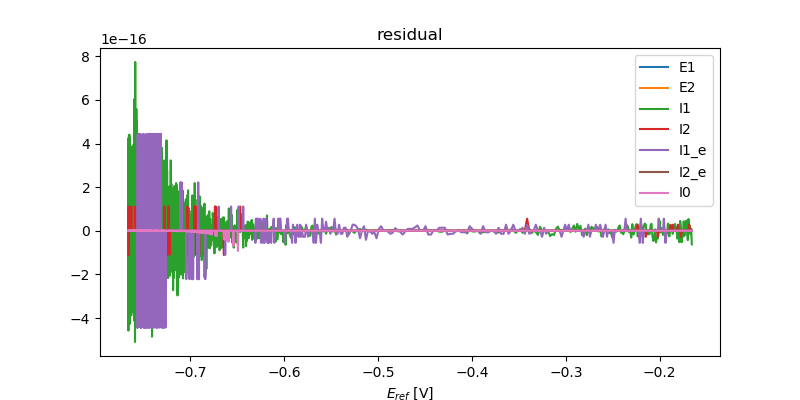

In [14]:
# Example
model = model_set(par1=par1, par2=par2 ,Area=AREA, A1=A1, A2=A2, R0=100, Re=10000)
model.solve(cathodic_range=-0.300,anodic_range=0.300,scan_step=0.005,plot_residual=True)




<IPython.core.display.Javascript object>


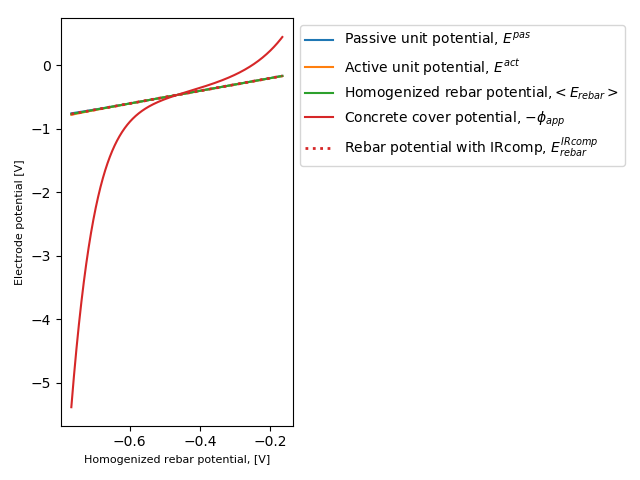

<IPython.core.display.Javascript object>


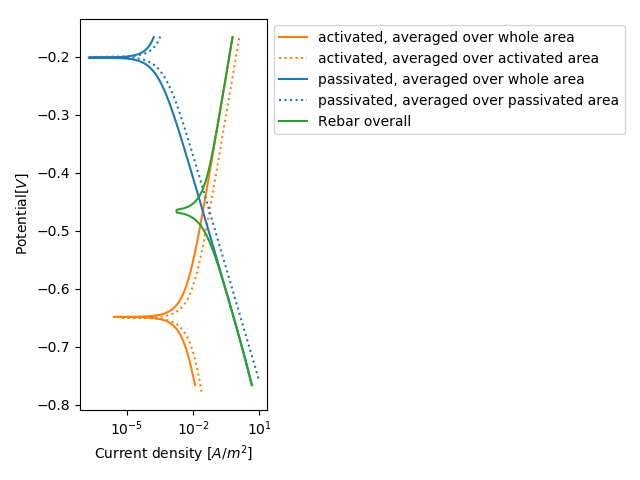

In [15]:
potential_plot(model)
Ei_plot_log(model)

In [41]:
print model.OCP
print model.icorr


-0.4660788595782458
0.027432139464796366


# parametric scan of Resistance

In [16]:
# set senario
model_list = [
              model_set(par1=par1, par2=par2 ,Area=AREA, A1=A1, A2=A2, R0=10000., Re=10000.),
              model_set(par1=par1, par2=par2 ,Area=AREA, A1=A1, A2=A2, R0=1000., Re=10000.),
              model_set(par1=par1, par2=par2 ,Area=AREA, A1=A1, A2=A2, R0=100., Re=10000.),
              model_set(par1=par1, par2=par2 ,Area=AREA, A1=A1, A2=A2, R0=10000., Re=1000.),
              model_set(par1=par1, par2=par2 ,Area=AREA, A1=A1, A2=A2, R0=1000., Re=1000.),
              model_set(par1=par1, par2=par2 ,Area=AREA, A1=A1, A2=A2, R0=100., Re=1000.),
              model_set(par1=par1, par2=par2 ,Area=AREA, A1=A1, A2=A2, R0=10000., Re=100.),
              model_set(par1=par1, par2=par2 ,Area=AREA, A1=A1, A2=A2, R0=1000., Re=100.), 
              model_set(par1=par1, par2=par2 ,Area=AREA, A1=A1, A2=A2, R0=100., Re=100.),
                ]
comment_list = [
              'Case 1', 
              'Case 2',
              'Case 3',
              'Case 4',
              'Case 5', 
              'Case 6',
              'Case 7',
              'Case 8',
              'Case 9',
               ]

for this_model, this_comment in zip(model_list,comment_list):
    this_model.comment = this_comment


# get solved model list
for model in model_list:
    model.solve(cathodic_range=-0.400,anodic_range=0.400,scan_step=0.01)



total residual 1.5151993657757377e-14
total residual 1.0076858081402651e-13
total residual 1.0316769037072334e-12
total residual 2.83949401758518e-15
total residual 6.7968680364270114e-15
total residual 2.2462809709837293e-14
total residual 2.6813250206561925e-15
total residual 3.2000099187088174e-15
total residual 4.0434028746864795e-15


<IPython.core.display.Javascript object>


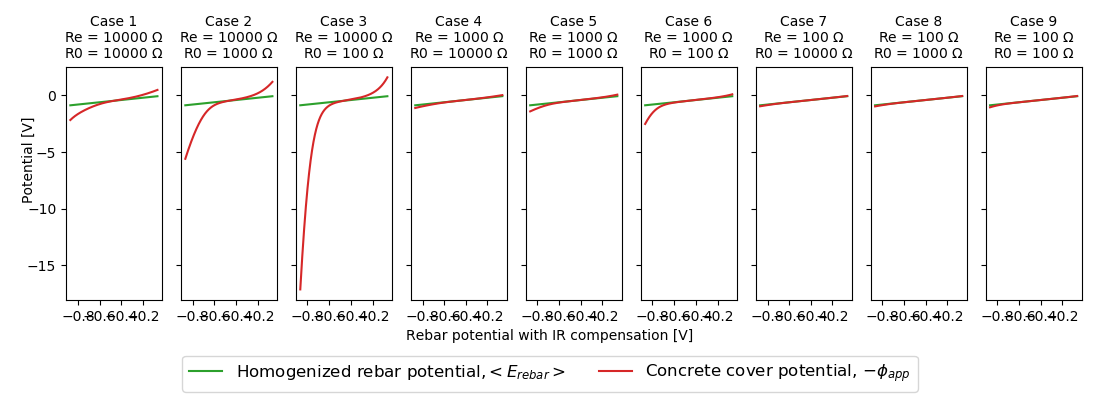

Text(0.02,0.6,'Potential [V]')

In [17]:
# applied potential vs homogenized

fig, subaxes = plt.subplots(1, 9, figsize=(11, 4),sharex=False, sharey=True)

for this_model, this_axis in zip(model_list, subaxes.flatten()):
    title = '{}\nRe = {:.0f} $\Omega$\nR0 = {:.0f} $\Omega$'.format(this_model.comment,this_model.Re, this_model.R0)
    plot_cover_potential_subplot(this_model, title, subplot=this_axis)

fig.legend(*this_axis.get_legend_handles_labels(), ncol=2, labelspacing=0.5,loc='lower center' ,fontsize=12)
fig.tight_layout(pad=1.08, w_pad=0.6, h_pad=1.0)
fig.subplots_adjust(left=0.06,bottom=0.25,hspace=0.5,wspace=0.2)
fig.text(0.5, 0.15, 'Rebar potential with IR compensation [V]', ha='center',fontsize=10)
fig.text(0.02, 0.6, 'Potential [V]', va='center', rotation='vertical')


<IPython.core.display.Javascript object>


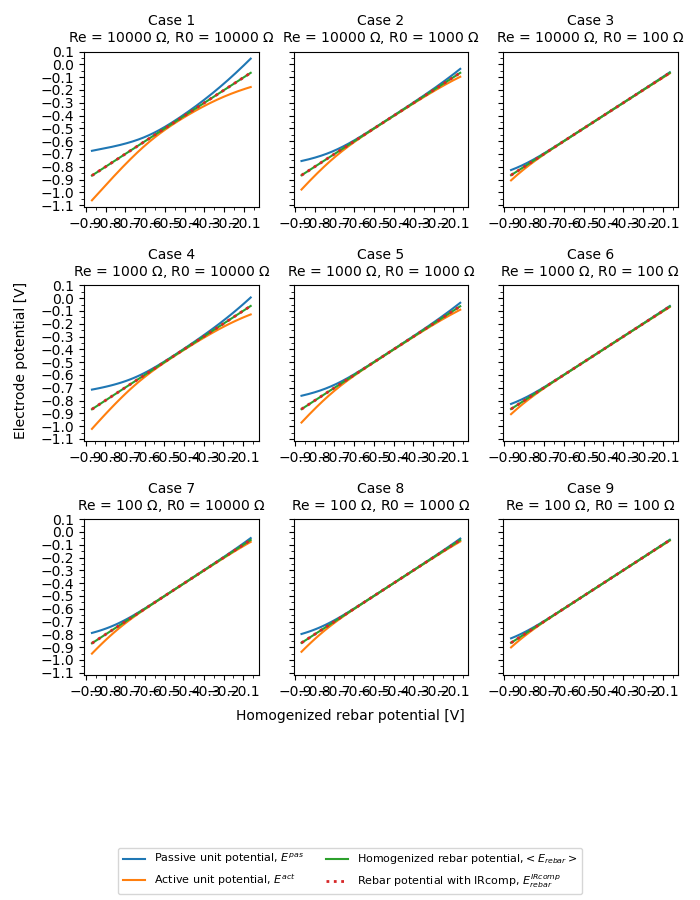

Text(0.02,0.6,'Electrode potential [V]')

In [18]:
fig, subaxes = plt.subplots(3, 3, figsize=(7, 9),sharex=False, sharey=True)

for this_model, this_axis in zip(model_list, subaxes.flatten()):
    title = '{}\nRe = {:.0f} $\Omega$, R0 = {:.0f} $\Omega$'.format(this_model.comment,this_model.Re, this_model.R0)
    plot_potential_subplot(this_model, title, subplot=this_axis)

fig.legend(*this_axis.get_legend_handles_labels(), ncol=2, labelspacing=0.5,loc='lower center' ,fontsize=8)
fig.tight_layout(pad=1.08, w_pad=0.7, h_pad=0.7)
fig.subplots_adjust(left=0.12,bottom=0.25,hspace=0.5,wspace=0.2)
fig.text(0.5, 0.2, 'Homogenized rebar potential [V]', ha='center')
fig.text(0.02, 0.6, 'Electrode potential [V]', va='center', rotation='vertical')


<IPython.core.display.Javascript object>


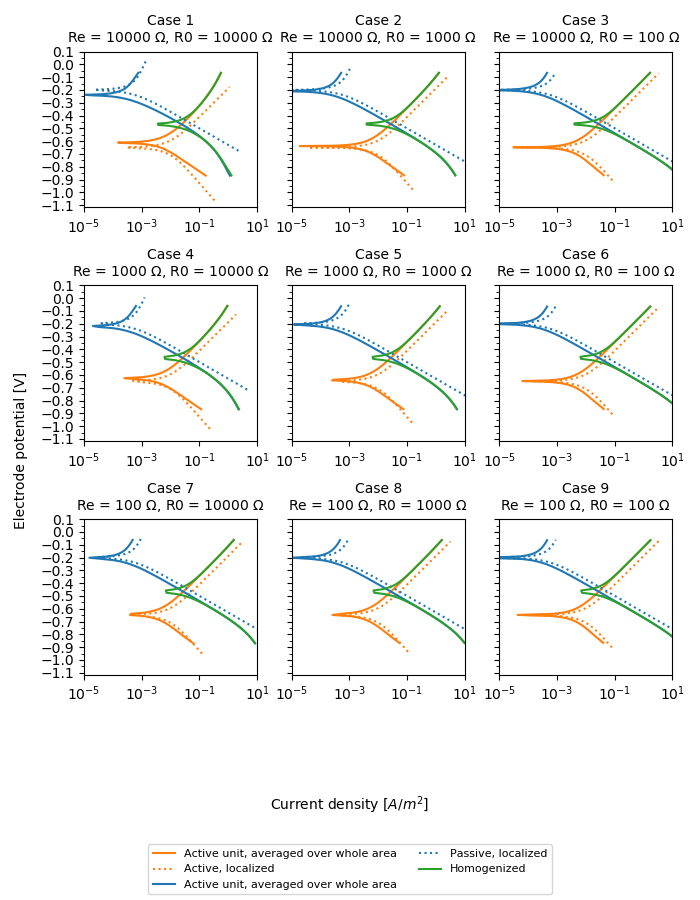

Text(0.02,0.5,'Electrode potential [V]')

In [19]:
fig, subaxes = plt.subplots(3, 3, figsize=(7, 9),sharex=False, sharey=True)

for this_model, this_axis in zip(model_list, subaxes.flatten()):
    title = '{}\nRe = {:.0f} $\Omega$, R0 = {:.0f} $\Omega$'.format(this_model.comment,this_model.Re, this_model.R0)
    plot_Ei_log_subplot(this_model, title, subplot=this_axis)

fig.legend(*this_axis.get_legend_handles_labels(), ncol=2, labelspacing=0.5,loc='lower center' ,fontsize=8)
fig.tight_layout(pad=1.08, w_pad=0.7, h_pad=0.7)
fig.subplots_adjust(left=0.12,bottom=0.25,hspace=0.5,wspace=0.2)

fig.text(0.5, 0.10, 'Current density $[A/m^2]$', ha='center')
fig.text(0.02, 0.5, 'Electrode potential [V]', va='center', rotation='vertical')
